# Sprint11
## 1次元の畳み込みニューラルネットワークスクラッチ

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
(X_train,y_train), (X_test,y_test)=mnist.load_data()
X_train,X_test=X_train.reshape(-1,784),X_test.reshape(-1,784)
X_train,X_test=X_train.astype(float)/255,X_test.astype(float)/255

In [0]:
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train=enc.fit_transform(y_train[:,np.newaxis])
y_test=enc.transform(y_test[:,np.newaxis])

In [0]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

In [0]:
class XavierInitializer():
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, filter_size):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        self.sigma=1/(math.sqrt(n_nodes1))
        W=self.sigma*np.random.randn(filter_size)
        
        return W
    
    def B(self):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        
        B=self.sigma*np.random.randn()
        
        return B
    

In [0]:
class AdaGrad():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
        #イテレーションごとの勾配の二乗和　初期値は０
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
            
        H_W=(layer.H_W + layer.dW * layer.dW)
        H_B=(layer.H_B + layer.dB * layer.dB)
        
        #０付近で割ると値が膨れ上がるのを防ぐ
        H_W[H_W<1]=1
        if H_B<1:
            H_B=1
        
        #print(H_W)
        #print(H_B)
            
        layer.W -= (self.lr /np.sqrt(H_W)) * layer.dW
        layer.B -= (self.lr /np.sqrt(H_B)) * layer.dB
        layer.H_W=H_W
        layer.H_B=H_B

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

### Conv1d class

In [0]:
class SimpleConv1d():
    
    def __init__(self,input_size, filter_size,optimizer, initializer=XavierInitializer,
                 ):
        """
        padding なし
        stride は１固定
        """
        self.padding=0
        self.stride=1
        
        self.input_size=input_size  #入力の特徴量の数　前層のノード数
        self.filter_size=filter_size
        self.output_size=self.output_s()
        self.initializer=initializer()
        
        #shape: (filter_size, )
        #self.W=self.initializer.W(self.input_size, self.filter_size)
        self.W=np.array([3,5,7]).astype(np.float)
        #shape: (output_size, )
        #self.B=self.initializer.B()
        self.B=np.array([1]).astype(np.float)
        
        self.optimizer=optimizer
        
        
        #AdaGradで使うやつ
        self.H_W=0
        self.H_B=0
    
    
    def forward(self, X):
        """
        X : 入力  １次元配列
        
        """
        self.X=X
        indexes = np.array([np.arange(i, i+self.filter_size) for i in range(self.output_size)]).astype(np.int)
        return ((X[indexes])*(self.W.reshape(1,-1))).sum(axis=1) + self.B
    
    def backward(self, dA):
        
        indexes = np.array([np.arange(i, i+self.filter_size) for i in range(self.output_size)]).astype(np.int)
        self.dW=(self.X[indexes] * (dA.reshape(-1,1))).sum(axis=0)
        self.dB=dA.sum()
        dX=np.zeros(self.X.shape[0])
        for i in range(self.output_size):
            dX[i:i+self.filter_size]+=dA[i]*self.W
        self = self.optimizer.update(self)
        
        return dX
    
    def output_s(self):
        
        return (self.input_size+2*self.padding-self.filter_size)//self.stride + 1
        

## 【問題2】1次元畳み込み後の出力サイズの計算

In [12]:
def N_Out(X,W,padding,stride):
        return ((X.shape[0]+2*padding-len(W))/stride)+1
    
#テスト
N_Out(x,w,1,1)

4.0

## 【問題3】小さな配列での1次元畳み込み層の実験

In [0]:
Conv=SimpleConv1d(input_size=4, filter_size=3, optimizer=AdaGrad())

In [11]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
Conv.forward(x)

array([35., 50.])

In [13]:
dA=np.array([10, 20])
print(Conv.backward(dA))
print(Conv.dW)
print(Conv.dB)

[ 30. 110. 170. 140.]
[ 50  80 110]
30


In [14]:
filter_size=3
output_size=2
indexes = np.array([np.arange(i, i+filter_size) for i in range(output_size)]).astype(np.int)
indexes

array([[0, 1, 2],
       [1, 2, 3]])

In [15]:
np.dot(x[indexes], w)+1

array([35, 50])

In [16]:
(x[indexes]*w).sum(axis=1) +1

array([35, 50])

In [0]:
dA=np.array([10, 20])
indexes = np.array([np.arange(i, i+filter_size) for i in range(output_size)]).astype(np.int)
dW=(x[indexes]*(dA.reshape(-1,1))).sum(axis=0)
dB=dA.sum()

In [0]:
print(dW)
print(dB)

[ 50  80 110]
30


In [0]:
dX=np.zeros(x.shape[0])
for i in range(output_size):
    print(w*dA[i])
    dX[i:i+filter_size]+=w*dA[i]

[30 50 70]
[ 60 100 140]


In [0]:
dX

array([ 30., 110., 170., 140.])

In [0]:
#工夫
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)

x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
x[indexes]

array([[1, 2, 3],
       [2, 3, 4]])

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

### Xavierの初期値

In [0]:
#Xavierの初期値
#Conv１D用に変更


class XavierInitializer_2():
    
    def __init__(self):
        pass
        
    def W(self, input_size, input_ch,  filter_size, n_filters):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        self.sigma=1/(math.sqrt(input_size))
        W=self.sigma*np.random.randn(n_filters, input_ch, filter_size)
        
        return W
    
    def B(self, n_filters):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        
        B=self.sigma*np.random.randn(n_filters)
        
        return B
    

### 最適化方法（AdaGrad）

In [0]:
class AdaGrad_2():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
        #イテレーションごとの勾配の二乗和　初期値は０
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
            
        H_W=(layer.H_W + layer.dW * layer.dW)
        H_B=(layer.H_B + layer.dB * layer.dB)
        
        #０付近で割ると値が膨れ上がるのを防ぐ
        H_W[H_W<1]=1
        if H_B<1:
            H_B=1
        
        #print(H_W)
        #print(H_B)
            
        layer.W -= (self.lr /np.sqrt(H_W)) * layer.dW
        layer.B -= (self.lr /np.sqrt(H_B)) * layer.dB
        layer.H_W=H_W
        layer.H_B=H_B

In [0]:
class SimpleConv1d_nc():
    
    def __init__(self,input_s, filter_s,  optimizer, initializer=XavierInitializer_2):
        """
        padding なし
        stride は１固定
        """
        self.padding=0
        self.stride=1
        
        self.input_s=input_s#(前層のチャンネル、前層のノード) tuple
        self.C=self.input_s[0]
        self.IS=self.input_s[1]
        
        self.filter_s=filter_s #filterの（フィルター数、サイズ） tuple
        self.FN=self.filter_s[0]
        self.FS=self.filter_s[2]
        
        self.output_s=self.output_size()
        self.initializer=initializer()
        
        #shape: (n_filters, filter_size, )
        #self.W=self.initializer.W(self.input_s[1], self.input_s[0], self.filter_s[1], self.filter_s[0])
        self.W=np.ones((3, 2, 3))
        #shape: (n_filters )
        #self.B=self.initializer.B(self.filter_s[0])
        self.B=np.array([1, 2, 3])
        
        self.optimizer=optimizer
        self.indexes = np.array([np.arange(i, i+self.filter_s[2]) for i in range(self.output_s)]).astype(np.int)
        
        
        #AdaGradで使うやつ
        self.H_W=0
        self.H_B=0
    
    
    def forward(self, X):
        """
        X : 入力  １次元配列
        
        """
        self.X=X
        
        
        """
        最初に思いついたやり方
        a=np.zeros((self.filter_s[2], self.output_s))
        for i in range(self.filter_s[0]):
            A=np.zeros((self.input_s[0],  self.output_s))
            for j in range(self.input_s[0]):
                A[j, :]=(x[j, :][indexes]*w[i, j, :]).sum(axis=1)
            a[i, :]=A.sum(axis=0)+b[i]
        
        """
       
        
        X_col=np.zeros((self.output_s, self.FS*self.C))
        for i in range(self.C):
            X_col[:self.output_s,i*self.FS:i*self.FS+self.FS]=X[i][self.indexes]
        w_1=self.W.reshape(-1, self.C*self.FS)
        
        a=(np.dot(X_col, w_1.T)+self.B).T
            
        return a
    
    def backward(self, dA):
        self.dB=dA.sum(axis=1)
        
        indexes = np.array([np.arange(i, i+self.filter_s[2]) for i in range(self.output_s)]).astype(np.int)
        
        """
        最初に思いついたやつ
        dX=np.zeros((self.input_s[0], self.input_s[1]))
        for i in range(self.filter_s[0]):
            for j in range(self.input_s[0]):
                for k in range(self.output_s):
                    dX[j, k:k+self.filter_s[2]]+=dA[i, k]*w[i, j, :]
        """
        #dX
        dX=np.zeros((2,4))
        for i in range(self.C):
            w_1=w.transpose(1,0,2)
            X_col=np.dot(w_1[i].T, dA )
            for j in range(self.output_s):
                dX[i, j:j+self.FS]+=X_col.T[j,:] 
                
                
        #dW        
        X_col=np.zeros((self.C, self.FS*self.output_s))
        for i in range(self.C):
            
            X_col[:self.output_s,i*self.FS:i*self.FS+self.FS]=self.X[i][self.indexes]
        

        D=np.dot(dA, X_col)
        self.dW=D.reshape(self.FN, -1, self.FS)
        
        return dX
    
    def output_size(self):
        
        return (self.input_s[1]+2*self.padding-self.filter_s[2])//self.stride + 1
        

In [0]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

In [0]:
conv=SimpleConv1d_nc(input_s=(2,4), filter_s=(3,2,3),  optimizer=AdaGrad(), initializer=XavierInitializer_2)

In [22]:
conv.FS

3

In [23]:
conv.forward(x)

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [0]:
input_size=4
n_filter=3
input_ch=2
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
w=np.array([[[1,1,2],[2,1,1]],[[2,1,1],[1,1,1]],[[1,1,1],[1,1,1]]])

dA=np.array([[9,11], [32, 35], [52,56]])
print(conv.backward(dA))
print(conv.dW)

[[125. 230. 204. 113.]
 [102. 206. 195. 102.]]
[[[ 31.  51.  71.]
  [ 51.  71.  91.]]

 [[102. 169. 236.]
  [169. 236. 303.]]

 [[164. 272. 380.]
  [272. 380. 488.]]]


In [0]:
filter_size=3
output_size=2

In [0]:
b

array([1, 2, 3])

In [0]:
w=np.ones((3,2,3))
n_filter=3
input_ch=2
a=np.zeros((filter_size, output_size))
for i in range(n_filter):
    A=np.zeros((input_ch,  output_size))
    for j in range(input_ch):
        A[j, :]=(x[j, :][indexes]*w[i, j, :]).sum(axis=1)
    a[i, :]=A.sum(axis=0) +b[i]
a

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [0]:
#二次元化の考えを用いたforward　間違ってたかも
x_col=np.zeros((input_ch, filter_size*output_size))
for i in range(input_ch):
    x_col[i, :]=x[i][indexes].flatten()

w_1=w.reshape(-1, input_ch*filter_size)
w_1.T
(np.dot(x_col, w_1.T)+b).T

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [0]:
#二次元化の考えを用いたforward 改 多分合ってる
x_col=np.zeros((output_size, filter_size*input_ch))
for i in range(input_ch):
    x_col[:output_size, filter_size*i:filter_size*i+filter_size]=x[i][indexes]

w_1=w.reshape(-1, input_ch*filter_size)
w_1.T
(np.dot(x_col, w_1.T)+b).T

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

In [0]:
x[0][indexes]

array([[1, 2, 3],
       [2, 3, 4]])

In [0]:
x_col

array([[1., 2., 3., 2., 3., 4.],
       [2., 3., 4., 3., 4., 5.]])

In [0]:
w_1=np.arange(1,19).reshape(3,2,3)
w_1

array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]],

       [[13, 14, 15],
        [16, 17, 18]]])

In [0]:
w_1.reshape(-1,6).T

array([[ 1,  7, 13],
       [ 2,  8, 14],
       [ 3,  9, 15],
       [ 4, 10, 16],
       [ 5, 11, 17],
       [ 6, 12, 18]])

In [25]:
input_size=4
n_filter=3
input_ch=2
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])
w=np.array([[[1,1,2],[2,1,1]],[[2,1,1],[1,1,1]],[[1,1,1],[1,1,1]]])

dA=np.array([[9,11], [32, 35], [52,56]])
dX=np.zeros((input_ch, input_size))
for i in range(n_filter):
    for j in range(input_ch):
        for k in range(output_size):
            dX[j, k:k+filter_size]+=dA[i, k]*w[i, j, :]
            print(dA[i, k]*w[i, j, :])
dX

[ 9  9 18]
[11 11 22]
[18  9  9]
[22 11 11]
[64 32 32]
[70 35 35]
[32 32 32]
[35 35 35]
[52 52 52]
[56 56 56]
[52 52 52]
[56 56 56]


array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

In [0]:
dX=np.zeros((2,4))
for i in range(input_ch):
    w_1=w.transpose(1,0,2)
    X_col=np.dot(w_1[i].T, dA )
    for j in range(output_size):
        dX[i, j:j+filter_size]+=X_col.T[j,:]
dX        

array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

In [0]:
w.transpose(1,0,2)

array([[[1, 1, 2],
        [2, 1, 1],
        [1, 1, 1]],

       [[2, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [0]:
#backward dW
x_col=np.zeros((input_ch, filter_size*output_size))
for i in range(input_ch):
    x_col[i, :]=x[i][indexes].flatten()

D=np.dot(dA, x_col)
D

array([[ 31.,  51.,  71.,  51.,  71.,  91.],
       [102., 169., 236., 169., 236., 303.],
       [164., 272., 380., 272., 380., 488.]])

In [0]:
dW=D.reshape(n_filter, -1, filter_size)
dW

array([[[ 31.,  51.,  71.],
        [ 51.,  71.,  91.]],

       [[102., 169., 236.],
        [169., 236., 303.]],

       [[164., 272., 380.],
        [272., 380., 488.]]])

## 【問題8】学習と推定

In [0]:
class SGD():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        

In [0]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1=n_nodes1
        self.n_nodes2=n_nodes2
        self.initializer=initializer
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        
        self.W=self.initializer.W(n_nodes1, n_nodes2)
        self.B=self.initializer.B(n_nodes2)
        
        #AdaGradで使うH
        self.H_W=0
        self.H_B=0
        
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        A=np.dot(X, self.W)+self.B
        self.input=X
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        
        Z: 前層の出力
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        # 更新
        dZ=np.dot(dA, self.W.T)
        self.dW=np.dot(self.input.T, dA)
        self.dB=dA.sum(axis=0)
        
        self = self.optimizer.update(self)
        return dZ


In [0]:
class Softmax():
    def __init__(self):
        pass
    
    
    def forward(self, y):
        """
        y: 前層の出力
        """
        #C=y.max()
        #y=y-C
        return np.exp(y)/(np.exp(y).sum(axis=1).reshape(-1,1))
    
    def backward(self, Z, y):
        
        """
        交差エントロピー誤差と合わせた勾配
        Z: softmax関数の出力
        y: 正解ラベル
        
        
        """
        
        dA=Z- y
        
        return dA
    
    

In [0]:
class Relu():
    
    def __init__(self):
        pass
    
    
    def forward(self, X):
        
        self.input=X
        return np.maximum(0, X)
    
    def backward(self, dZ):
        
        boo= (self.input>0).astype(int)
        return dZ*boo

In [0]:
#Heの初期値


class HeInitializer():
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        self.sigma=math.sqrt(2/n_nodes1)
        W=self.sigma*np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        
        B=self.sigma*np.random.randn(n_nodes2)
        
        return B
    

In [0]:
class AdaGrad():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
        #イテレーションごとの勾配の二乗和　初期値は０
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
            
        H_W=layer.H_W + layer.dW * layer.dW
        H_B=layer.H_B + layer.dB * layer.dB
        
        #０付近で割ると値が膨れ上がるのを防ぐ
        H_W[H_W<1]=1
        H_B[H_B<1]=1
        
        #print(H_W.max())
        #print(H_B.max())
            
        layer.W -= (self.lr /np.sqrt(H_W)) * layer.dW
        layer.B -= (self.lr /np.sqrt(H_B)) * layer.dB
        layer.H_W=H_W
        layer.H_B=H_B

In [0]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [0]:
class equal():
    
    def forward(self, X):
        return X
    
    def backward(self, dZ):
        return dZ

In [0]:
class SimpleConv1d():
    
    def __init__(self,input_size, filter_size,optimizer, initializer=XavierInitializer,
                 ):
        """
        padding なし
        stride は１固定
        """
        self.padding=0
        self.stride=1
        
        self.input_size=input_size  #入力の特徴量の数　前層のノード数
        self.filter_size=filter_size
        self.output_size=self.output_s()
        self.initializer=initializer()
        
        #shape: (filter_size, )
        self.W=self.initializer.W(self.input_size, self.filter_size)
        #self.W=np.array([3,5,7]).astype(np.float)
        #shape: (output_size, )
        self.B=self.initializer.B()
        #self.B=np.array([1]).astype(np.float)
        
        self.optimizer=optimizer
        
        
        #AdaGradで使うやつ
        self.H_W=0
        self.H_B=0
    
    
    def forward(self, X):
        """
        X : 入力  １次元配列
        
        """
        self.X=X
        indexes = np.array([np.arange(i, i+self.filter_size) for i in range(self.output_size)]).astype(np.int)
        
        X=X.reshape(-1)
        return (((X[indexes])*(self.W.reshape(1,-1))).sum(axis=1) + self.B).reshape(1,-1)
    
    def backward(self, dA):
        
        indexes = np.array([np.arange(i, i+self.filter_size) for i in range(self.output_size)]).astype(np.int)
        self.dW=((self.X.reshape(-1)[indexes] * (dA.reshape(-1,1))).sum(axis=0)).reshape(-1)
        self.dB=dA.sum()
        dX=np.zeros(self.X.shape[1])
        for i in range(self.output_size):
            
            dX[i:i+self.filter_size]+=(dA[:,i][0])*self.W
        self = self.optimizer.update(self)
        
        return dX
    
    def output_s(self):
        
        return (self.input_size+2*self.padding-self.filter_size)//self.stride + 1
        

In [0]:
class SDNN_n():
    """
    DNN

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, layers, activations,  n_epochs=50, batch_size=600, 
                 verbose = True):
        
        """
        layers 層のリスト
        activations 活性化関数のリスト　（最後はソフトマックスで、lossは誤差エントロピー）
        """
        self.layers=layers
        self.activations=activations
        
        
        self.n_epochs=n_epochs
        self.batch_size=batch_size
        self.verbose = verbose
        

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
            or ONE-HOT 化されたやつ渡すか
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
         
        self.loss=[]
        self.val_loss=[]
        self.accuracy = []
        self.val_accuracy = []
        #ミニバッチを取得
        for i in range(self.n_epochs):
            
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X, mini_y in get_mini_batch:
                #forward
                
                Z=self.all_forward(mini_X)[1]
                
                
                #backward
                dA = self.activations[-1].backward(Z, mini_y)
                dZ = self.layers[-1].backward(dA)
                
                for j in range(2, len(self.layers)+1):
                    
                    dA = self.activations[-j].backward(dZ) 
                    dZ = self.layers[-j].backward(dA)
                
                
            
            y_pred=self.all_forward(X)[1]
            loss_=self.loss_function(y, y_pred)
            self.loss.append(loss_)
            # 正解率
            accuracy_ = self.accuracy_function(X,y, y_pred)
            self.accuracy.append(accuracy_)
            
            if X_val is not None:
                y_val_pred=self.all_forward(X_val)[1]
                val_loss_=self.loss_function(y_val, y_val_pred)
                self.val_loss.append(val_loss_)
                # 正解率
                val_accuracy_ = self.accuracy_function(X,y, y_pred)
                self.val_accuracy.append(val_accuracy_)
        
    
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                if X_val is not None:
                    print("epoch{}     loss: {}   val_loss: {}   accuracy: {}   val_accuracy: {}".format(i+1, loss_, val_loss_, accuracy_, val_accuracy_))
                    
                else:
                    print("epoch{}     loss: {} ".format(i+1, loss_))


        #verboseをTrueにした際は学習過程などを出力
        if X_val is not None:
            plt.rcParams["font.size"] = 16
            fig, ax = plt.subplots(1, 2, figsize=(20,9))
            ax[0].plot(np.arange(1, len(self.loss)+1), self.loss, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[0].set_xlabel("epoch numbers")
            ax[0].set_ylabel("cost value (averaged)")
            ax[1].plot(np.arange(1, len(self.accuracy)+1), self.accuracy, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[1].set_xlabel("epoch numbers")
            ax[1].set_ylabel("accuracy")
            # 検証データも学習したら可視化
            if len(self.val_loss) > 0:
                ax[0].plot(np.arange(1, len(self.val_loss)+1), self.val_loss, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
                ax[1].plot(np.arange(1, len(self.val_accuracy)+1), self.val_accuracy, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
            ax[0].legend()
            ax[1].legend()
            plt.show()
                

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        
        

 
        
        pred=self.all_forward(X)[0].argmax(axis=1)
        
        
        return pred
    
    def all_forward(self, X):
        Z=X
        for i in range(len(self.layers)):
            A = self.layers[i].forward(Z)
            Z = self.activations[i].forward(A)
            
        
        return A,Z
    
    
    
    
    def loss_function(self, y_true, y_pred):
        
        #真数０を防ぐために微小な値を足す
        delta=1e-7
        L=-(y_true*np.log(y_pred+delta)).sum()/y_pred.shape[0]
        
        return L
    
        
    def normalize(self, X):
        
        return (X-X.min())/(X.max()-X.min())

    def accuracy_function(self, X, y_true, y_pred):
        y = np.argmax(y_pred, axis = 1)# 一番確率の高いラベルのインデックスを出す
        t = np.argmax(y_true, axis = 1)# 正解ラベルのインデックスを出す one-hot法

        accuracy = (y == t).sum() / float(X.shape[0])
        return accuracy


In [0]:
n_features=784

sigma=0.01 #SimpleInitializerの時のみ使用
layers=[]
activations=[]
optimizer=AdaGrad(lr=0.01)

layers.append(FC(n_features, 600,HeInitializer(), optimizer=optimizer))
activations.append(Relu())
layers.append(FC(600, 400, HeInitializer(), optimizer=optimizer))
activations.append(Relu())
layers.append(SimpleConv1d(input_size=400, filter_size=3,  optimizer=SGD(), initializer=XavierInitializer))
activations.append(equal())
layers.append(FC(398, 200, HeInitializer(), optimizer=optimizer))
activations.append(Relu())
layers.append(FC(200, 10, HeInitializer(), optimizer=optimizer))
activations.append(Softmax())

epoch1     loss: 2.35620549653434   val_loss: 2.3741836978687427   accuracy: 0.0   val_accuracy: 0.0
epoch2     loss: 2.2929574877920884   val_loss: 2.3189399836518216   accuracy: 0.0   val_accuracy: 0.0
epoch3     loss: 2.230693256281397   val_loss: 2.266865375341865   accuracy: 0.0   val_accuracy: 0.0
epoch4     loss: 2.1656095548092553   val_loss: 2.2086826851538692   accuracy: 0.0   val_accuracy: 0.0
epoch5     loss: 2.093145175510553   val_loss: 2.1424542367151873   accuracy: 0.0   val_accuracy: 0.0
epoch6     loss: 2.004937518382954   val_loss: 2.066150172075619   accuracy: 1.0   val_accuracy: 1.0
epoch7     loss: 1.8941253701585115   val_loss: 1.9683437784811997   accuracy: 1.0   val_accuracy: 1.0
epoch8     loss: 1.7522213117970624   val_loss: 1.8397540837741422   accuracy: 1.0   val_accuracy: 1.0
epoch9     loss: 1.5847839519050981   val_loss: 1.6867970527171126   accuracy: 1.0   val_accuracy: 1.0
epoch10     loss: 1.3784522225224305   val_loss: 1.4901768850370152   accuracy: 

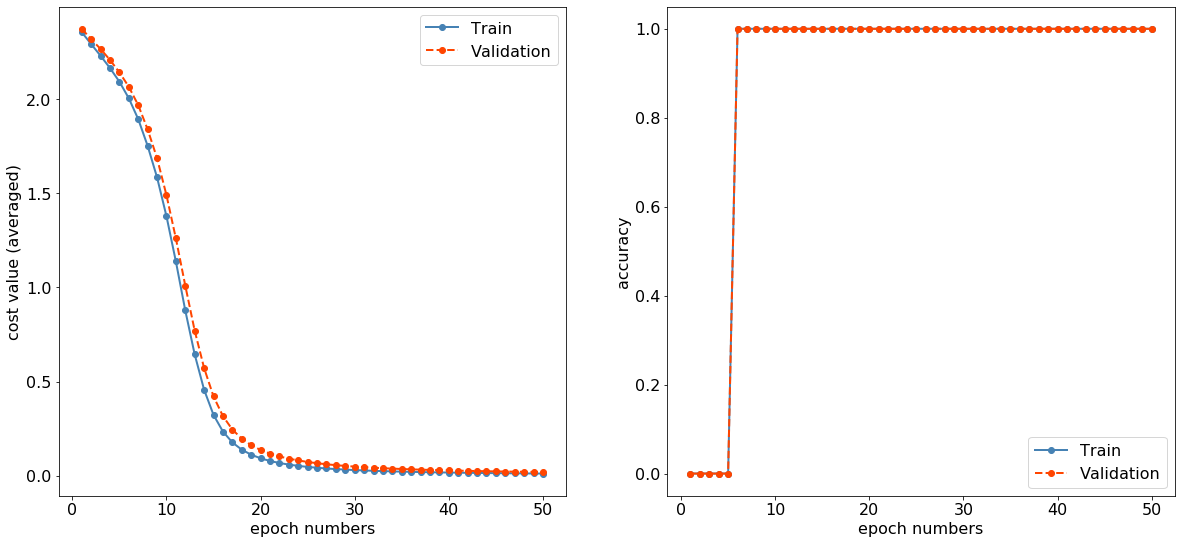

In [161]:
dnn=SDNN_n(layers=layers, activations=activations, batch_size=1, n_epochs=50)
dnn.fit(X_train[0].reshape(1,-1), y_train[0].reshape(1,-1), X_test[0].reshape(1,-1), y_test[0].reshape(1,-1))
y_pred=dnn.predict(X_test)

In [0]:
学習時間短縮のため、１つのデータで実行